In [1]:
from aiida.plugins import DataFactory
import aiida
aiida.load_profile()

Profile<uuid='aaaefae20eac49f892e60b4593a470e3' name='quicksetup'>

In [2]:
from aiida.plugins import WorkflowFactory
from aiida.orm import Float, load_node
from aiida.engine import run,submit,workfunction, WorkChain, ToContext, while_
import numpy as np
import time

# StableXChainの作成

spec.outlineでより複雑な手順を定義する。

In [3]:
# global variable isn't good.
# forcechain = WorkflowFactory("stablex.force")
# energychain = WorkflowFactory("stablex.energy")
# newxchain = WorkflowFactory("stablex.sd_new_x")

class StableXChain(WorkChain):
    @classmethod
    def define(cls,spec):
        super().define(spec)
        spec.input("x", valid_type=Float)
        spec.input("a", valid_type=Float)
        spec.input("fth", valid_type=Float)
        spec.outline(cls.initialize,
                     cls.force,
                   while_ (cls.not_converged)(
                   cls.new_x,
                   cls.force
                   ),
                    cls.finalize)
        spec.output("stable_x", valid_type=Float)
        spec.output("stable_force", valid_type=Float)

    def initialize(self):
        # internal variable
        self.ctx._iteration = 0
        self.ctx._iteration_max = 100 # 突然だがiterationの最大値をつけておく。
        
    def force(self):
        if "new_x" in self.ctx:
            x = self.ctx.new_x.outputs.new_x
        else:
            x = self.inputs.x
        forcechain = WorkflowFactory("stablex.force")
        force_builder = forcechain.get_builder()
        force_builder.x = x
        # run() doesn't work here.
        # submit() must be used. 
        future = self.submit(force_builder)
        self.to_context(**{"force": future})
        
    def not_converged(self):
        f = self.ctx.force.outputs.force
        fth = self.inputs.fth
        iteration = self.ctx._iteration
        print("i,f,fth",iteration, f.value, fth.value)
        return np.abs(f.value) > fth.value and self.ctx._iteration < self.ctx._iteration_max

    def new_x(self):
        if "new_x" in self.ctx:
            x = self.ctx.new_x.outputs.new_x
        else:
            x = self.inputs.x
        f = self.ctx.force.outputs.force
        a = self.inputs.a
        newxchain = WorkflowFactory("stablex.sd_new_x")
        newx_builder = newxchain.get_builder()
        newx_builder.x = x
        newx_builder.f = f
        newx_builder.a = a
        future = self.submit(newx_builder)
        self.to_context(**{"new_x": future})
        self.ctx._iteration += 1
        
    def finalize(self):
        if "new_x" in self.ctx:
            x = self.ctx.new_x.outputs.new_x
        else:
            x = self.inputs.x    
        self.out("stable_x",x)
        f = self.ctx.force.outputs.force
        self.out("stable_force",f)

## runによる実行

In [4]:
x0 = Float(2)
a = Float(0.6)
fth = Float(1e-3)

inputs = {"x":x0, "a":a, "fth":fth}
print(inputs)

result, node =  run.get_node(StableXChain, **inputs)

{'x': <Float: uuid: 96339907-e135-468d-bb42-7d0322a22e45 (unstored) value: 2.0>, 'a': <Float: uuid: eb8bb7e0-342a-4a12-9ec8-203c872b0d25 (unstored) value: 0.6>, 'fth': <Float: uuid: 5c21f762-0fcf-4c77-a78e-d6d00f5d8a94 (unstored) value: 0.001>}
i,f,fth 0 -4.0 0.001
i,f,fth 1 0.8 0.001
i,f,fth 2 -0.16 0.001
i,f,fth 3 0.032 0.001
i,f,fth 4 -0.0064 0.001
i,f,fth 5 0.00128 0.001
i,f,fth 6 -0.000256 0.001


In [5]:
result

{'stable_x': <Float: uuid: d4030b8e-f39e-40a9-ba6e-102bbfe9ff01 (pk: 9309) value: 0.000128>,
 'stable_force': <Float: uuid: bb4fe097-db79-445c-a272-e1bcf54e565a (pk: 9312) value: -0.000256>}

9309
Success: Output written to `9309.dot.pdf`


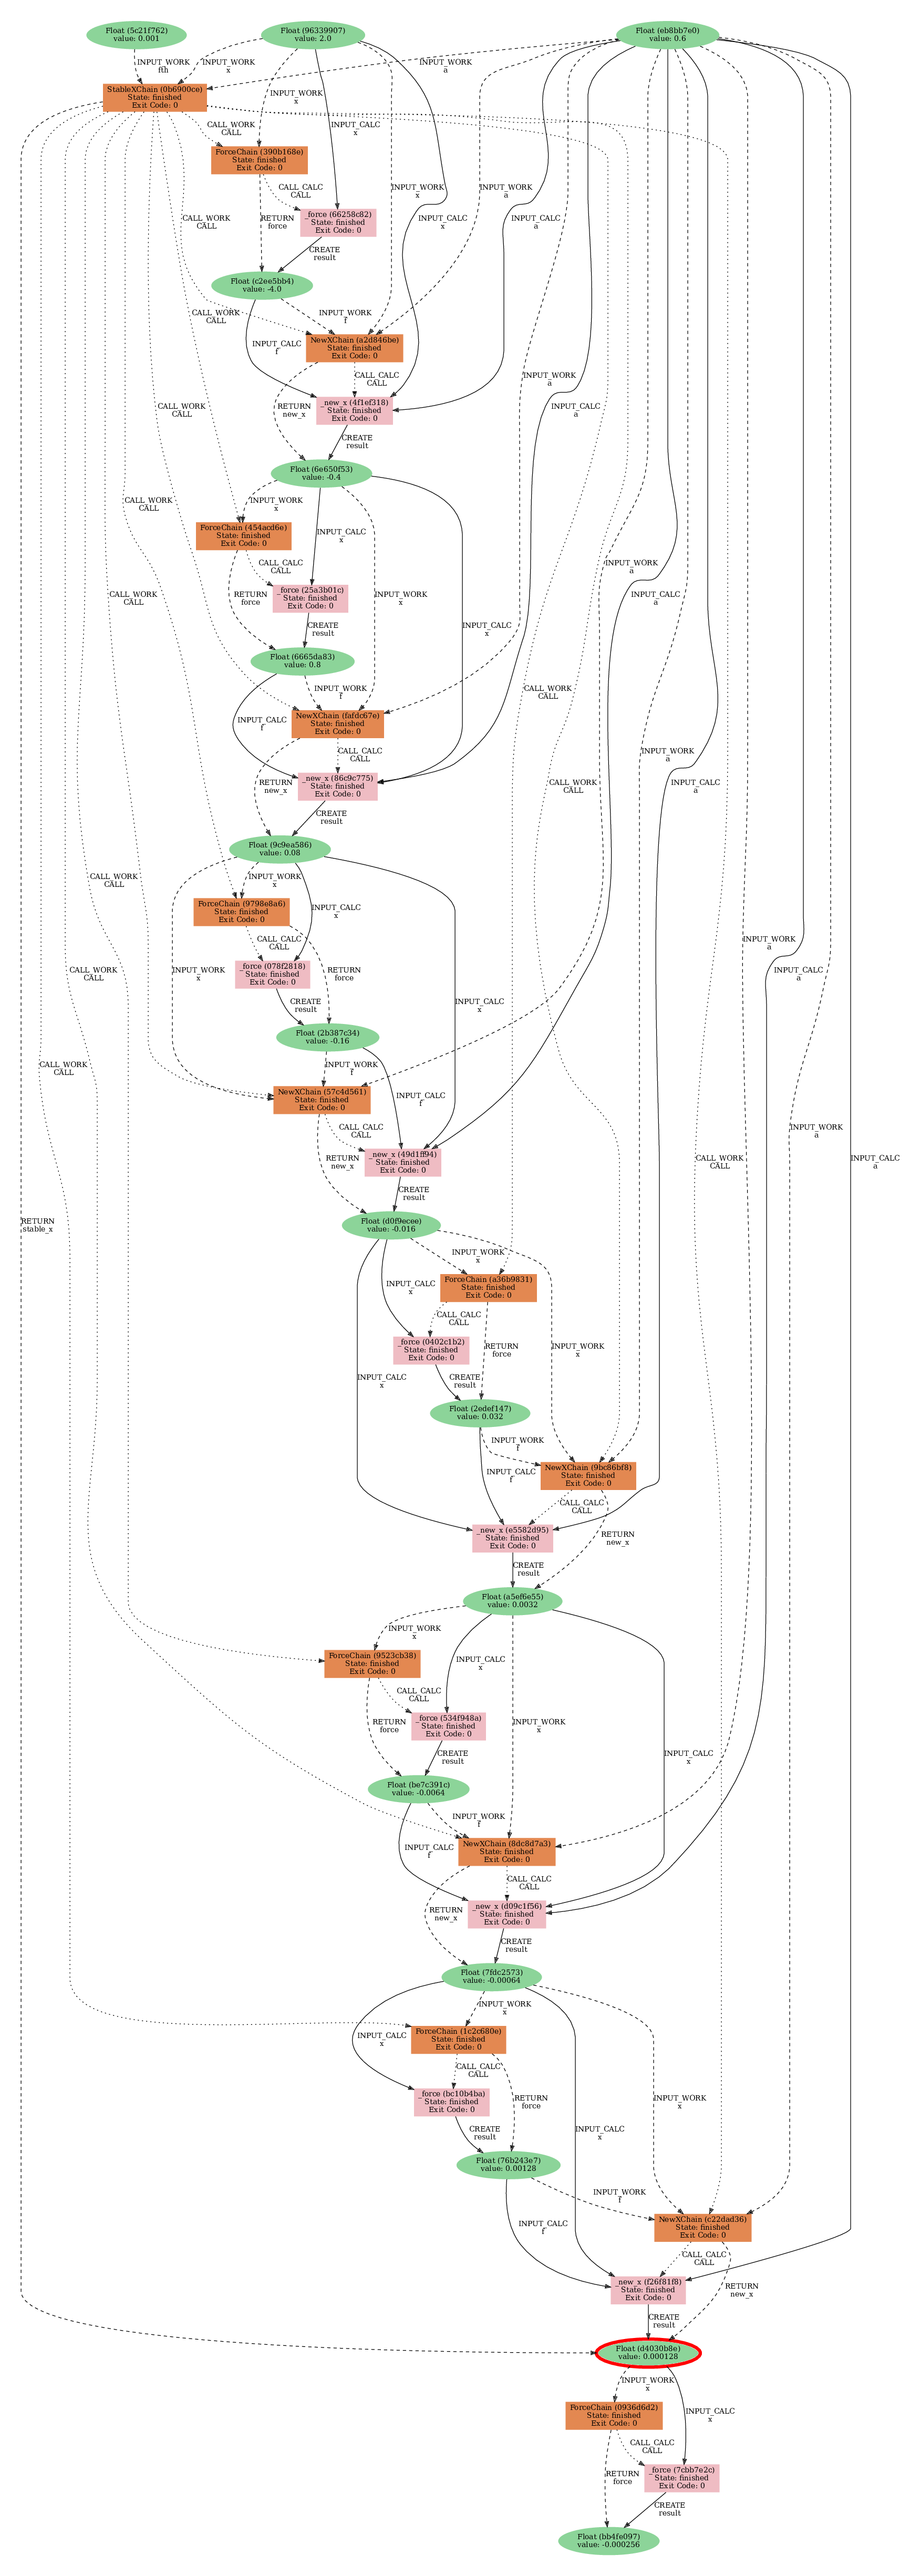

In [6]:
# This graph is big.
pk = result["stable_x"].pk
print(pk)
import subprocess
cmd = "verdi node graph generate {}".format(pk)
subprocess.call(cmd,shell=True)

from wand.image import Image as WImage
WImage(filename="{}.dot.pdf".format(pk))

次にStableXChainを外部ファイル化してworkchainとして読み込む。